In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# IMAGE SEGMENTATION AND FEATURE EXTRACTION FRAMEWORK FOR GIST DATA

In the  GIST_img_preprocessing script we already described our dataset. Here we will work from the resulting images obtained from that workflow.

Actually, as stated at the end of that script, segmenting is a very complex and crucial step in the analysis of images. Due to time reasons, we will make use of a segmenting online tool called Deep cell (https://www.deepcell.org)

In this tool they address the problem of cell segmentation in tissue imaging data through large-scale data annotation and deep learning. They constructed TissueNet, an image dataset containing >1 million paired whole-cell and nuclear annotations for tissue images from nine organs and six imaging platforms. Then created Mesmer, a deep learning-enabled segmentation algorithm trained on TissueNet that performs nuclear and whole-cell segmentation in tissue imaging data. (https://www.biorxiv.org/content/10.1101/2021.03.01.431313v2) 

Aided by this tool, we created segmentation masks for the dapi+control channels of each sample A-N.

Unfortunately, these masks are not perfect and some readjustments will be needed. This is the task we face in the present script.

In [7]:
#Import libraries needed
import numpy as np #library for dealing with arrays (image=array)
import pandas as pd #library for dealing with databases
from matplotlib import pyplot as plt #plotting library
import random

# Loading our images:

We will load the preprocesed bi(dapi+control)-channel images A-N and their masks.

In [3]:
from skimage import io # skimage = library for image analysis // io = function for loading images.
names = ('LLRO_A', 'LLRO_B', 'LLRO_C', 'LLRO_G', 'LLRO_H', 'LLRO_I', 'LLRO_L', 'LLRO_M','LLRO_N', 'LLRO_O',
        'LRRO_A', 'LRRO_G', 'LRRO_J', 'LRRO_K', 'LRRO_L', 'LRRO_M',
        'ULRO_A', 'ULRO_B', 'ULRO_C', 'ULRO_F', 'ULRO_G', 'ULRO_H', 'ULRO_I', 'ULRO_J', 'ULRO_K', 'ULRO_L', 'ULRO_M', 'ULRO_N',
        'URRO_A', 'URRO_B', 'URRO_C', 'URRO_D', 'URRO_G', 'URRO_H', 'URRO_I', 'URRO_J', 'URRO_M', 'URRO_N')

preprocessed = {}

#LLRO
letter_LLRO = ['A', 'B', 'C', 'G', 'H', 'I', 'L', 'M', 'N', 'O']
j=0
for i in letter_LLRO:
    preprocessed[names[j]] = io.imread('./preprocessed/20210621-GIST-TMA-SBR-LLR0-A01-pp'+i+ '.tif')
    j=j+1

#LRRO
letter_LRRO = ['A', 'G', 'J', 'K', 'L', 'M']
for i in letter_LRRO:
    preprocessed[names[j]] = io.imread('./preprocessed/20210621-GIST-TMA-SBR-LRRO-A01-pp'+ i + '.tif')
    j+=1
    
#ULRO
letter_ULRO = ['A', 'B', 'C', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']
for i in letter_ULRO:
    preprocessed[names[j]] = io.imread('./preprocessed/20210621-GIST-TMA-SBR-ULRO-A01-pp'+ i + '.tif')
    j+=1
    
#URRO
letter_URRO = ['A', 'B', 'C', 'D', 'G', 'H', 'I', 'J', 'M', 'N']
for i in letter_URRO:
    preprocessed[names[j]] = io.imread('./preprocessed/20210621-GIST-TMA-SBR-URR0-A01-pp'+ i + '.tif')
    j+=1

In [4]:
print(preprocessed.keys())
print(len(preprocessed.keys()))

dict_keys(['LLRO_A', 'LLRO_B', 'LLRO_C', 'LLRO_G', 'LLRO_H', 'LLRO_I', 'LLRO_L', 'LLRO_M', 'LLRO_N', 'LLRO_O', 'LRRO_A', 'LRRO_G', 'LRRO_J', 'LRRO_K', 'LRRO_L', 'LRRO_M', 'ULRO_A', 'ULRO_B', 'ULRO_C', 'ULRO_F', 'ULRO_G', 'ULRO_H', 'ULRO_I', 'ULRO_J', 'ULRO_K', 'ULRO_L', 'ULRO_M', 'ULRO_N', 'URRO_A', 'URRO_B', 'URRO_C', 'URRO_D', 'URRO_G', 'URRO_H', 'URRO_I', 'URRO_J', 'URRO_M', 'URRO_N'])
38


we want our images to have the shape (x row pixels, y column pixels, c channels). 

In [5]:
#check our new shape:
print('Old shape preprocesed images: {0}'.format(np.shape(preprocessed['LLRO_A']))) #hipermatrix of 12 channels
for im in preprocessed: #loop across every object (image) in the dictionary.
        #Check if the images are the right shape: we want to have (rows, columns, channels)  
        rows = preprocessed[im].shape[0] #number of rows
        cols = preprocessed[im].shape[1] #number of columns
        if rows < 100:
            preprocessed[im] = np.moveaxis(preprocessed[im], 0, 2) #reestructuring of image matrix
        elif cols < 100:
            preprocessed[im] = np.moveaxis(preprocessed[im], 1, 2) #reestructuring of image matrix
        
#check our new shape:
print('New shape preprocesed images: {0}'.format(np.shape(preprocessed['LLRO_A']))) #hipermatrix of 12 channels

Old shape preprocesed images: (12, 1280, 1280)
New shape preprocesed images: (1280, 1280, 12)


# Inspecting our pre-processed images:
We now have 14 images of 14 different patients each of them with 2 different channels.

- CH0  --> dapi (405nm)
- CH1  --> control (the wavelength for the obtention of this control may change)

We inspected the masks on fiji and the masks for the cell body are not precise enough and therefore we will not work with them yet. For now, we will only study the cell's nuclei.

Text(0.5, 1.0, 'LLRO_A - Dapi (405nm)')

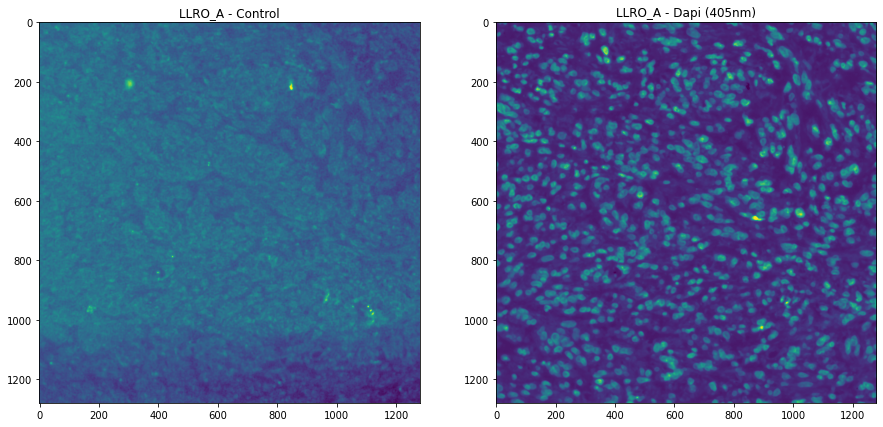

In [18]:
i=0
# 0: LLRO_A, 1: LLRO_B, 2: LLRO_C, 3: LLRO_G, 4: LLRO_H', 5: LLRO_I, 6: LLRO_L, 7: LLRO_M, 8: LLRO_N, 9: LLRO_O
# 10: LRRO_A, 11: LRRO_G', 12: LRRO_J, 13: LRRO_K, 14: LRRO_L, 15: LRRO_M
#16: ULRO_A, 17: ULRO_B, 18: ULRO_C, 19: ULRO_F, 20: ULRO_G, 21: ULRO_H, 22: ULRO_I, 23: ULRO_J, 24: ULRO_K, 25: ULRO_L, 26: ULRO_M, 27: ULRO_N
#28: URRO_A, 29: URRO_B, 30: URRO_C, 31: URRO_D, 32: URRO_G, 33: URRO_H, 34: URRO_I, 35: URRO_J, 36: URRO_M, 37: URRO_N

fig, ax = plt.subplots(1, 2, figsize=(15,15)) #we create a figure with two subplots (1row, 2columns)
ax[0].imshow(preprocessed[names[i]][:,:,1]) #what we plot in the subplot1
ax[0].set_title(names[i] + ' - Control') #subplot title
ax[1].imshow(preprocessed[names[i]][:,:,0])  #what we plot in the subplot2
ax[1].set_title(names[i] + ' - Dapi (405nm)') #subplot title

Although it is not shown in this script, we have used several segmentation methods, some of them based on neural networks other in the selection of a threshold through a ML method for the posterior application of the watershed algorithm.

In the pdf called "segmentation-methods" you will find which segmentation method worked better with each dapi channel of each sample.

# Segmentation of our images
Unlike single-cell RNA sequencing, image-based transcriptomics methods do not physically separate cells before acquiring RNA information. Therefore, in order to characterize cells, the RNA must be assigned into single cells by partitioning the image volume. Accurate unsupervised cell-segmentation is an open problem for all biomedical imaging disciplines ranging from digital pathology to neuroscience.

The challenge of segmenting cells depends on the structural complexity of the sample and quality of images available. For example, a sparse cell mono-layer with a strong cytosol stain would be trivial to segment but a dense heterogeneous population of cells in 3D tissue with only a DAPI stain can be impossible to segment perfectly. On the experimental side, selecting good cell stains and acquiring images with low background will make segmenting a more tractable task.

There are many approaches for segmenting cells from image-based transcriptomics assays. If you do not know which segmentation method to use, a safe bet is to start with thresholding and watershed. On the other hand, if you can afford to manually define ROI masks there is no better way to guarantee accurate segmentation.

### a) Yen threshold + distance transformation + Watershed

- **Yen method for threshold selection:** Thresholding is used to create a binary image from a grayscale image. It is the simplest way to segment objects from a background. It is based on the histogram of the image. (Yen threshold method explained: https://ieeexplore.ieee.org/document/366472)

- **Distance transformation:** The distance transform of a binary image is the distance from every pixel to the nearest nonzero-valued pixel. It helps improve the results from applying the watershed algorithm. 

- **Watershed algorithm:** The watershed is a classical algorithm used for segmentation, that is, for separating different objects in an image. Starting from user-defined markers (provided by the binare image obtained through Yen's threshold), the watershed algorithm treats pixels values as a local topography (elevation). The algorithm floods basins from the markers until basins attributed to different markers meet on watershed lines. In many cases, markers are chosen as local minima of the image, from which basins are flooded. (great explanation of the watershed algorithm: https://es.mathworks.com/company/newsletters/articles/the-watershed-transform-strategies-for-image-segmentation.html)

This segmentation method was applied to samples but in the end other methods provided a more precise segmentation of the nuclei.

In [64]:
"""import copy
temp = copy.deepcopy(preprocessed)

dapi_ch = {}
otsu_letter = (names[14],names[28])

#i= #12, 14, 17, 18, 20, 21, 24, 26, 28, 31
# 0: LLRO_A, 1: LLRO_B, 2: LLRO_C, 3: LLRO_G, 4: LLRO_H', 5: LLRO_I, 6: LLRO_L, 7: LLRO_M, 8: LLRO_N, 9: LLRO_O
# 10: LRRO_A, 11: LRRO_G', 12: LRRO_J, 13: LRRO_K, 14: LRRO_L, 15: LRRO_M
#16: ULRO_A, 17: ULRO_B, 18: ULRO_C, 19: ULRO_F, 20: ULRO_G, 21: ULRO_H, 22: ULRO_I, 23: ULRO_J, 24: ULRO_K, 25: ULRO_L, 26: ULRO_M, 27: ULRO_N
#28: URRO_A, 29: URRO_B, 30: URRO_C, 31: URRO_D, 32: URRO_G, 33: URRO_H, 34: URRO_I, 35: URRO_J, 36: URRO_M, 37: URRO_N


#Store the selected preprocessed images in the "dapi_ch" dictionary:
for i in otsu_letter:
    dapi_ch["{0}".format(i)] = temp[i][:,:,0]
print(dapi_ch.keys())"""

dict_keys(['LRRO_L', 'URRO_A'])


In [67]:
"""#Find the otsu threshold:
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed
from scipy.ndimage.morphology import distance_transform_edt
from skimage import util 

binary = {}
masks = {}

for sample in otsu_letter:
    img = dapi_ch[sample]

    thresh = threshold_otsu(img) #select a threshold
    binary[sample] = img > thresh #create the binary image 
    
    masks[sample] = watershed(img, 1800, mask=binary[sample])"""

In [72]:
"""masks.keys()"""

dict_keys(['LRRO_L', 'URRO_A'])

Text(0.5, 1.0, 'mask')

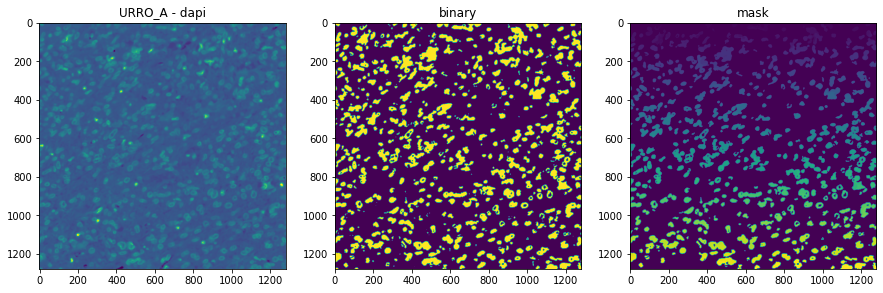

In [70]:
#Visualize our results:
i = 1 #0: LRRO_L, 1: URRO_A

fig, ax = plt.subplots(1, 3, figsize=(15,15)) #we create a figure with two subplots (1row, 2columns)
ax[0].imshow(dapi_ch[otsu_letter[i]]) #what we plot in the subplot1
ax[0].set_title(otsu_letter[i] +' - dapi') #subplot title
ax[1].imshow(binary[otsu_letter[i]])  #what we plot in the subplot2
ax[1].set_title('binary') #subplot title
ax[2].imshow(masks[otsu_letter[i]])  #what we plot in the subplot2
ax[2].set_title('mask') #subplot title

### b) Cellpose
Cellpose is a deep learning-based segmentation algorithm, which can very precisely segment a wide range of image types out-of-the-box and does not require model retraining or parameter adjustments. Cellpose is trained  on a new dataset of highly-varied images of cells, containing over 70,000 segmented objects. The model is periodically retrained on the community-contributed data to ensure that Cellpose improves constantly.

This segmentation method was applied to samples G, I and K.

In [6]:
import copy
temp = copy.deepcopy(preprocessed)

dapi_ch = {}

cellpose_letter = (names[12],names[17],names[18],names[20],names[21],names[24],names[26],names[28],names[31])

#Store the selected preprocessed images in the "dapi_ch" dictionary:
for i in cellpose_letter:
    dapi_ch["{0}".format(i)] = temp[i][:,:,0]
print(dapi_ch.keys())

dict_keys(['LRRO_J', 'ULRO_B', 'ULRO_C', 'ULRO_G', 'ULRO_H', 'ULRO_K', 'ULRO_M', 'URRO_A', 'URRO_D'])


In [7]:
from cellpose import models, io
model = models.Cellpose(gpu=False, model_type='nuclei')
channels = [0,0]
masks={}
for i in cellpose_letter:
    image = dapi_ch[i]
    masks[i], flows, styles, diams = model.eval(image, diameter=18, channels=channels)

2021-09-02 16:29:41,763 [INFO] WRITING LOG OUTPUT TO /Users/lobo/.cellpose/run.log
2021-09-02 16:29:41,793 [INFO] >>>> using CPU
2021-09-02 16:29:42,021 [INFO] ~~~ FINDING MASKS ~~~
2021-09-02 16:32:16,184 [INFO] >>>> TOTAL TIME 154.16 sec
2021-09-02 16:32:16,191 [INFO] ~~~ FINDING MASKS ~~~
2021-09-02 16:34:44,774 [INFO] >>>> TOTAL TIME 148.58 sec
2021-09-02 16:34:44,779 [INFO] ~~~ FINDING MASKS ~~~
2021-09-02 16:37:11,100 [INFO] >>>> TOTAL TIME 146.32 sec
2021-09-02 16:37:11,114 [INFO] ~~~ FINDING MASKS ~~~
2021-09-02 16:39:43,181 [INFO] >>>> TOTAL TIME 152.07 sec
2021-09-02 16:39:43,191 [INFO] ~~~ FINDING MASKS ~~~
2021-09-02 16:42:10,451 [INFO] >>>> TOTAL TIME 147.26 sec
2021-09-02 16:42:10,458 [INFO] ~~~ FINDING MASKS ~~~
2021-09-02 16:44:39,225 [INFO] >>>> TOTAL TIME 148.77 sec
2021-09-02 16:44:39,231 [INFO] ~~~ FINDING MASKS ~~~
2021-09-02 16:47:13,339 [INFO] >>>> TOTAL TIME 154.11 sec
2021-09-02 16:47:13,345 [INFO] ~~~ FINDING MASKS ~~~
2021-09-02 16:49:41,742 [INFO] >>>> TOTAL

In [15]:
masks.keys()

dict_keys(['LRRO_J', 'ULRO_B', 'ULRO_C', 'ULRO_G', 'ULRO_H', 'ULRO_K', 'ULRO_M', 'URRO_A', 'URRO_D', 'LLRO_A', 'LLRO_B', 'LLRO_C', 'LLRO_G', 'LLRO_H', 'LLRO_I', 'LLRO_L', 'LLRO_M', 'LLRO_N', 'LLRO_O', 'LRRO_A', 'LRRO_G', 'LRRO_K', 'LRRO_L', 'LRRO_M', 'ULRO_A', 'ULRO_F', 'ULRO_I', 'ULRO_J', 'ULRO_L', 'ULRO_N', 'URRO_B', 'URRO_C', 'URRO_G', 'URRO_H', 'URRO_I', 'URRO_J', 'URRO_M', 'URRO_N'])

Text(0.5, 1.0, 'mask')

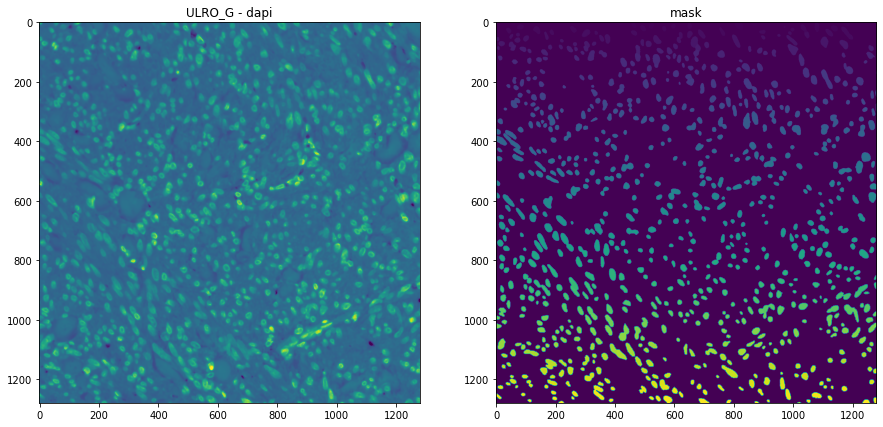

In [43]:
#Visualize our results:
i = 4 #0: LRRO_J, 2: ULRO_B, 4: ULRO_G, -7: ULRO_M, 8: URRO_A, 9: URRO_D-

fig, ax = plt.subplots(1, 2, figsize=(15,15)) #we create a figure with two subplots (1row, 2columns)
ax[0].imshow(dapi_ch[cellpose_letter[i]]) #what we plot in the subplot1
ax[0].set_title(cellpose_letter[i] +' - dapi') #subplot title
ax[1].imshow(masks2[cellpose_letter[i]])  #what we plot in the subplot2
ax[1].set_title('mask') #subplot title

### c) Deepcell
We already talked before about this method. For more info, refer yourself to the original paper (https://www.biorxiv.org/content/10.1101/2021.03.01.431313v2)

This segmentation method was applied to samples A, B, C, D and H.

In [9]:
deepcell_letter = [names[0], names[1], names[2],names[3],names[4],names[5],names[6],names[7],names[8],names[9],
                   names[10],names[11],names[13],names[14], names[15], names[16],names[19], names[22], names[23],names[25],
                   names[27],names[29],names[30], names[32], names[33], names[34], names[35], names[36], 
                   names[37]]

#i= 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 19, 22, 23, 25, 27, 29, 30, 32, 33, 34, 35, 36, 37
# 0: LLRO_A, 1: LLRO_B, 2: LLRO_C, 3: LLRO_G, 4: LLRO_H', 5: LLRO_I, 6: LLRO_L, 7: LLRO_M, 8: LLRO_N, 9: LLRO_O
# 10: LRRO_A, 11: LRRO_G', 12: LRRO_J, 13: LRRO_K, 14: LRRO_L, 15: LRRO_M
#16: ULRO_A, 17: ULRO_B, 18: ULRO_C, 19: ULRO_F, 20: ULRO_G, 21: ULRO_H, 22: ULRO_I, 23: ULRO_J, 24: ULRO_K, 25: ULRO_L, 26: ULRO_M, 27: ULRO_N
#28: URRO_A, 29: URRO_B, 30: URRO_C, 31: URRO_D, 32: URRO_G, 33: URRO_H, 34: URRO_I, 35: URRO_J, 36: URRO_M, 37: URRO_N


#Store the selected preprocessed images in the "dapi_ch" dictionary:
for i in deepcell_letter:
    dapi_ch["{0}".format(i)] = temp[i][:,:,0]
print(dapi_ch.keys())

dict_keys(['LRRO_J', 'ULRO_B', 'ULRO_C', 'ULRO_G', 'ULRO_H', 'ULRO_K', 'ULRO_M', 'URRO_A', 'URRO_D', 'LLRO_A', 'LLRO_B', 'LLRO_C', 'LLRO_G', 'LLRO_H', 'LLRO_I', 'LLRO_L', 'LLRO_M', 'LLRO_N', 'LLRO_O', 'LRRO_A', 'LRRO_G', 'LRRO_K', 'LRRO_L', 'LRRO_M', 'ULRO_A', 'ULRO_F', 'ULRO_I', 'ULRO_J', 'ULRO_L', 'ULRO_N', 'URRO_B', 'URRO_C', 'URRO_G', 'URRO_H', 'URRO_I', 'URRO_J', 'URRO_M', 'URRO_N'])


In [10]:
#comprobacion de que no hay nombres repes:
masks_names = np.array(list(masks.keys()))
all_masks_names = np.append(masks_names, np.array(deepcell_letter))

if (len(masks_names)+len(deepcell_letter))==len(all_masks_names):
    print('Everything seems to be fine. First check passed.')
    if ((len(np.unique(all_masks_names)))==(len(all_masks_names))):
        print('Proceed. Second check also passed.')
    else:
        print('It seems we have repeted the segmentation of one image with different methods. Check for no overlap NOT passed.')
else:
    print('We messed up.')
    

Everything seems to be fine. First check passed.
Proceed. Second check also passed.


In [11]:
len(masks_names)

9

In [12]:
#Load the masks obtained via deepcell:

#LLRO 'A', 'B', 'C', 'G', 'H', 'I', 'L', 'M', 'N', 'O'
letter_LLRO = ['A', 'B', 'C', 'G', 'H', 'I', 'L', 'M', 'N', 'O']
j=0
for i in letter_LLRO:
    masks[deepcell_letter[j]] = io.imread('./preprocessed/deep-cell/20210621-GIST-TMA-SBR-LLR0-A01-pp'+i+ '_feature_1.tif')
    j=j+1

#LRRO 'A', 'G', 'J', 'K', 'L', 'M'
letter_LRRO = ['A', 'G', 'K','L', 'M']
for i in letter_LRRO:
    masks[deepcell_letter[j]] = io.imread('./preprocessed/deep-cell/20210621-GIST-TMA-SBR-LRRO-A01-pp'+ i + '_feature_1.tif')
    j+=1
    
#ULRO 'A', 'B', 'C', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'
letter_ULRO = ['A', 'F', 'I','J', 'L', 'N']
for i in letter_ULRO:
    masks[deepcell_letter[j]] = io.imread('./preprocessed/deep-cell/20210621-GIST-TMA-SBR-ULRO-A01-pp'+ i + '_feature_1.tif')
    j+=1
    
#URRO 'A', 'B', 'C', 'D', 'G', 'H', 'I', 'J', 'M', 'N'
letter_URRO = ['B', 'C', 'G', 'H', 'I', 'J', 'M', 'N']
for i in letter_URRO:
    masks[deepcell_letter[j]] = io.imread('./preprocessed/deep-cell/20210621-GIST-TMA-SBR-URR0-A01-pp'+ i + '_feature_1.tif')
    j+=1

In [13]:
len(masks.keys())

38

In [14]:
#LETS DO ANOTHER CHECK:
#comprobacion de que no hay nombres repes:
masks_names = np.array(list(masks.keys()))

if (len(masks_names))==len(all_masks_names):
    print('Everything seems to be fine. First check passed.')
    if ((len(np.unique(all_masks_names)))==(len(np.unique(masks_names)))):
        print('Proceed. Second check also passed.')
    else:
        print('It seems we have repeted the segmentation of one image with different methods. Check for no overlap NOT passed.')
else:
    print('We messed up.')
    

Everything seems to be fine. First check passed.
Proceed. Second check also passed.


# Cleaning our masks
It is possible that some overlapping nuclei appear as just one big object or that small unidentified objects were also detected. We want to delete these from our masks. Will do this on the bases of area and roundness of the blobs in our masks.

However, we'll do this after we have extracted our features.

# Save our masks

In [21]:
from tifffile import imsave
for im in masks:
    imsave('./masks/20210621-GIST-TMA-SBR-A01-nuclei-'+ im + '.tif', masks[im])

# Feature extraction

Once we have detected our objects, we can proceed to obtain interesting features from our nuclei like, for example:

*From our segmentation masks:*
* Area
* Periemter
* Centroid's coordinates (row,col)
* Orientation
* Roundness
* Number of nuclei

*Summary features:*
* Mean
* Standard deviation
* Quantiles for a color channel

*From texture:* (I am not sure if measuring texture in just the nucleus makes sense, specially when the image has been blurred for denoising purposes) --dapi for div
* Contrast measurements (Contrast, dissimilarity, homogeneity)
* Ordliness measurements (ASM)
* Correlation

In [4]:
#Reload our images:
from skimage import io # skimage = library for image analysis // io = function for loading images.
names = ('LLRO_A', 'LLRO_B', 'LLRO_C', 'LLRO_G', 'LLRO_H', 'LLRO_I', 'LLRO_L', 'LLRO_M','LLRO_N', 'LLRO_O',
        'LRRO_A', 'LRRO_G', 'LRRO_J', 'LRRO_K', 'LRRO_L', 'LRRO_M',
        'ULRO_A', 'ULRO_B', 'ULRO_C', 'ULRO_F', 'ULRO_G', 'ULRO_H', 'ULRO_I', 'ULRO_J', 'ULRO_K', 'ULRO_L', 'ULRO_M', 'ULRO_N',
        'URRO_A', 'URRO_B', 'URRO_C', 'URRO_D', 'URRO_G', 'URRO_H', 'URRO_I', 'URRO_J', 'URRO_M', 'URRO_N')

preprocessed = {}
masks = {}

#LLRO
letter_LLRO = ['A', 'B', 'C', 'G', 'H', 'I', 'L', 'M', 'N', 'O']
j=0
for i in letter_LLRO:
    preprocessed[names[j]] = io.imread('./preprocessed/20210621-GIST-TMA-SBR-LLR0-A01-pp'+i+ '.tif')
    masks[names[j]] = io.imread('./masks/20210621-GIST-TMA-SBR-A01-nuclei-'+names[j]+ '.tif')
    j=j+1

#LRRO
letter_LRRO = ['A', 'G', 'J', 'K', 'L', 'M']
for i in letter_LRRO:
    preprocessed[names[j]] = io.imread('./preprocessed/20210621-GIST-TMA-SBR-LRRO-A01-pp'+ i + '.tif')
    masks[names[j]] = io.imread('./masks/20210621-GIST-TMA-SBR-A01-nuclei-'+ names[j] + '.tif')
    j+=1
    
#ULRO
letter_ULRO = ['A', 'B', 'C', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']
for i in letter_ULRO:
    preprocessed[names[j]] = io.imread('./preprocessed/20210621-GIST-TMA-SBR-ULRO-A01-pp'+ i + '.tif')
    masks[names[j]] = io.imread('./masks/20210621-GIST-TMA-SBR-A01-nuclei-'+ names[j] + '.tif')
    j+=1
    
#URRO
letter_URRO = ['A', 'B', 'C', 'D', 'G', 'H', 'I', 'J', 'M', 'N']
for i in letter_URRO:
    preprocessed[names[j]] = io.imread('./preprocessed/20210621-GIST-TMA-SBR-URR0-A01-pp'+ i + '.tif')
    masks[names[j]] = io.imread('./masks/20210621-GIST-TMA-SBR-A01-nuclei-'+ names[j] + '.tif')
    j+=1

In [14]:
for i in preprocessed: #loop across every object (image) in the dictionary.
        #Check if the images are the right shape: we want to have (rows, columns, channels)  
        rows1 = preprocessed[i].shape[0] #number of rows
        cols1 = preprocessed[i].shape[1] #number of columns
        rows2 = masks[i].shape[0] #number of rows
        cols2 = masks[i].shape[1] #number of columns
        
        if rows1 < 100:
            preprocessed[i] = np.moveaxis(preprocessed[i], 0, 2) #reestructuring of image matrix
            
        elif cols1 < 100:
            preprocessed[i] = np.moveaxis(preprocessed[i], 1, 2) #reestructuring of image matrix
            
        if rows2 < 100:
            masks[i] = np.moveaxis(masks[i], 0, 2) #reestructuring of image matrix
        elif cols2 < 100:
            masks[i] = np.moveaxis(masks[i], 1, 2) #reestructuring of image matrix

In [15]:
#check our new shape:
print('New shape preprocesed images: {0}'.format(np.shape(preprocessed[names[0]]))) #hipermatrix of 12 channels
print('New shape masks: {0}'.format(np.shape(masks[names[0]]))) #hipermatrix of 12 channels

New shape preprocesed images: (1280, 1280, 12)
New shape masks: (1280, 1280, 1)


Text(0.5, 1.0, 'mask')

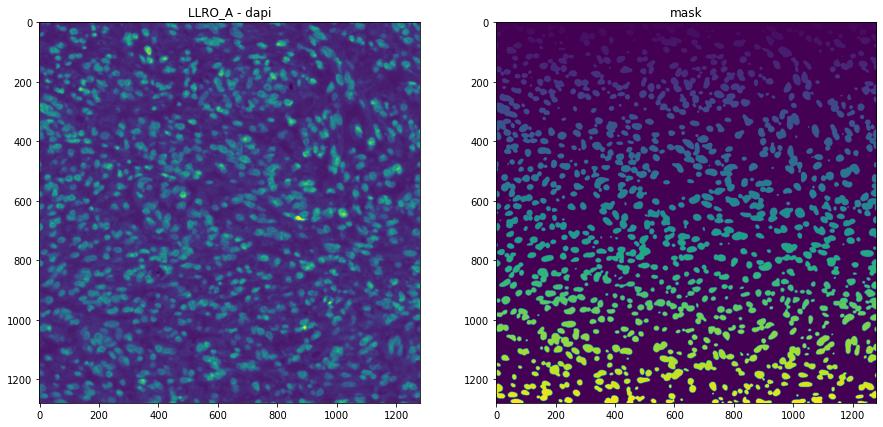

In [16]:
#Visualize our results:
patient = names[0]
fig, ax = plt.subplots(1, 2, figsize=(15,15)) #we create a figure with two subplots (1row, 2columns)
ax[0].imshow(preprocessed[patient][:,:,0]) #what we plot in the subplot1
ax[0].set_title(patient +' - dapi') #subplot title
ax[1].imshow(masks[patient])  #what we plot in the subplot2
ax[1].set_title('mask') #subplot title

### 1) Creation of our dataframe to store the features
**DataFrame:** Two-dimensional, size-mutable, potentially heterogeneous tabular data. This data structure also contains labeled axes (rows and columns).

* Rows: cell index --> {1,2,3,4,...,?}
* Columns: features --> {c. coordinatex, c. coordinatey, area, perimeter, orientation, roundness, mean_chi, std_chi, contrast_chi, ASM_chi, correlation_chi} (chi=channel i)

In [17]:
#Number of detected objects we have:
objects = 0
for i in masks:
    objects += len(np.unique(masks[i]))
print('Number of potential nuclei: {0}'.format(objects))

Number of potential nuclei: 45960


In [18]:
# array with indexes 
index = np.linspace(1, objects, objects, dtype=int)

#Empty feature-arrays
area=np.array([])
centroid_x = np.array([])
centroid_y = np.array([])
eccentricity = np.array([])
mean_pRb1 = np.array([])
std_pRb1 = np.array([])
mean_Rb1 = np.array([])
std_Rb1 = np.array([])
mean_Cyclin = np.array([])
std_Cyclin = np.array([])
mean_p16 = np.array([])
std_p16 = np.array([])
mean_p53 = np.array([])
std_p53 = np.array([])
"""#texture features only for dapi channel in order to see if we can detect a dividing cell.
homogeneity = np.array([])
AMS = np.array([])"""

coords = np.empty((0,2))

In [21]:
from skimage.measure import regionprops
from skimage.feature import greycomatrix, greycoprops
from skimage.util import img_as_uint

#features obtained from the dapi channel
for i in masks:
    mask_features = regionprops(label_image=np.squeeze(masks[i].astype(int)), intensity_image=preprocessed[i][:,:,0])
    
    area = np.append(area,np.array([prop.filled_area for prop in mask_features]))
    eccentricity = np.append(eccentricity, np.array([prop.eccentricity for prop in mask_features]))

In [22]:
print('area')
print(area.shape)

print('eccentricity')
print(eccentricity.shape)

area
(91844,)
eccentricity
(91844,)


In [ ]:
"""from skimage.measure import regionprops
from skimage.feature import greycomatrix, greycoprops
from skimage.util import img_as_uint

for i in masks:
    mask_features = regionprops(label_image=np.squeeze(masks[i].astype(int)), intensity_image=img[i][:,:,0])
    #texture features of the dapi channel
    for prop in mask_features:
            bbbox_limits = prop.bbox #bbox = (min_row, min_col, max_row, max_col), type=tupple
            #Pixels in the bounding box are in the half-open interval [min_row; max_row) & [min_col; max_col)
            rows = bbbox_limits[2]-bbbox_limits[0] #number of rows in the blob bounting box (bbbox)
            cols = bbbox_limits[3]-bbbox_limits[1] #number of cols in the blob bounting box (bbbox)
            temp_bbbox_values=np.empty((rows,cols)) #temporal empty bbbox
            temp_bbbox_mask=np.empty((rows,cols)) #temporal empty bbbox
            x=0
            y=0
            for row in np.arange(bbbox_limits[0],bbbox_limits[2]):
                for col in np.arange(bbbox_limits[1],bbbox_limits[3]):
                    temp_bbbox_values[x,y]= img[i][row,col,0]
                    temp_bbbox_mask[x,y]= masks[i][row,col]
                    y+=1
                x+=1
                y=0
            masked_blob = temp_bbbox_values*temp_bbbox_mask
            print('hola')
            #greycomatrix function requires an array of integers.
            unit_masked_blob=img_as_uint(masked_blob) #greycomatrix doest support float images
            print('caracola')
            glcm = greycomatrix(unit_masked_blob, distances=[4], angles=[0], levels=65536, symmetric=True, normed=True) 
            print('porfa funciona')
            filt_glcm = glcm[1:, 1:, :, :] #we delete from the glcm the values corresponding to pixels surrounded by zeros ()
            print('porfaaaaa')
            homogeneity = np.append(homogeneity, greycoprops(filt_glcm, prop='homogeneity'))
            AMS = np.append(AMS, greycoprops(filt_glcm, prop='AMS'))"""

In [23]:
#features obtained from additional markers
from skimage.measure import regionprops
from skimage.feature import greycomatrix, greycoprops
from skimage.util import img_as_uint
for i in masks:
    mask_features = regionprops(label_image=np.squeeze(masks[i].astype(int)), intensity_image=preprocessed[i][:,:,0])
    pRb1_features = regionprops(label_image=np.squeeze(masks[i].astype(int)), intensity_image=preprocessed[i][:,:,4])
    Rb1_features = regionprops(label_image=np.squeeze(masks[i].astype(int)), intensity_image=preprocessed[i][:,:,5])
    Cyclin_features = regionprops(label_image=np.squeeze(masks[i].astype(int)), intensity_image=preprocessed[i][:,:,7])
    p16_features = regionprops(label_image=np.squeeze(masks[i].astype(int)), intensity_image=preprocessed[i][:,:,8])
    p53_features = regionprops(label_image=np.squeeze(masks[i].astype(int)), intensity_image=preprocessed[i][:,:,11])
    
    mean_pRb1 = np.append(mean_pRb1, np.array([prop.mean_intensity for prop in pRb1_features]))
    mean_Rb1 = np.append(mean_Rb1, np.array([prop.mean_intensity for prop in Rb1_features]))
    mean_Cyclin = np.append(mean_Cyclin, np.array([prop.mean_intensity for prop in Cyclin_features]))
    mean_p16 = np.append(mean_p16, np.array([prop.mean_intensity for prop in p16_features]))
    mean_p53 = np.append(mean_p53, np.array([prop.mean_intensity for prop in p53_features]))
    
    for prop in mask_features:
        blob_coords = prop.coords
        temp_blob_values_pRb1=np.array([])
        temp_blob_values_Rb1=np.array([])
        temp_blob_values_Cyclin=np.array([])
        temp_blob_values_p16=np.array([])
        temp_blob_values_p53=np.array([])
        for pxl in blob_coords:
            temp_blob_values_pRb1=np.append(temp_blob_values_pRb1, preprocessed[i][pxl[0],pxl[1],4])
            temp_blob_values_Rb1=np.append(temp_blob_values_Rb1, preprocessed[i][pxl[0],pxl[1],5])
            temp_blob_values_Cyclin=np.append(temp_blob_values_Cyclin, preprocessed[i][pxl[0],pxl[1],7])
            temp_blob_values_p16=np.append(temp_blob_values_p16, preprocessed[i][pxl[0],pxl[1],8])
            temp_blob_values_p53=np.append(temp_blob_values_p53, preprocessed[i][pxl[0],pxl[1],11])
            
        std_pRb1 = np.append(std_pRb1, np.std(temp_blob_values_pRb1))
        std_Rb1 = np.append(std_Rb1, np.std(temp_blob_values_Rb1))
        std_Cyclin = np.append(std_Cyclin, np.std(temp_blob_values_Cyclin))
        std_p16 = np.append(std_p16, np.std(temp_blob_values_p16))
        std_p53 = np.append(std_p53, np.std(temp_blob_values_p53))

In [27]:
print('mean_pRb1')
print(len(mean_pRb1))


print('std_pRb1')
print(len(std_pRb1))

mean_pRb1
45922
std_pRb1
45922


In [28]:
sample_indicator = np.array(['GIST_1', 'GIST_2', 'GIST_4', 'GIST_5', 'GIST_6', 'GIST_7', 'GIST_9', 'GIST_10', 'GIST_11', 'GIST_13', 'GIST_14', 'GIST_15','GIST_16', 'GIST_17','GIST_18','GIST_19','GIST_20','GIST_21'])
cancer_risk = np.array(['metastatic', 'metastatic', 'low', 'metastatic', 'metastatic', 'low', 'metastatic', 'metastatic', 'metastatic', 'low', 'metastatic', 'metastatic','low', 'intermediate','low','intermediate','low','low'])

In [29]:
#dictionary to store the extracted features
features_dict = {
    'sample': sample_indicator,
    'area': area,
    'eccentricity': eccentricity,
    'mean_pRb1': mean_pRb1,
    'std_pRb1': std_pRb1,
    'mean_Rb1': mean_Rb1,
    'std_Rb1': std_Rb1,
    'mean_Cyclin': mean_Cyclin,
    'std_Cyclin': std_Cyclin,
    'mean_p16': mean_p16,
    'std_p16': std_p16,
    'mean_p53': mean_p53,
    'std_p53': std_p53, 
    'cancer_risk': cancer_risk
}


features = pd.DataFrame(features_dict, 
                columns = ['sample',
                           'area',
                           'eccentricity', 
                           'mean_pRb1',
                           'std_pRb1',
                           'mean_Rb1',
                           'std_Rb1',
                           'mean_Cyclin',
                           'std_Cyclin',
                           'mean_p16',
                           'std_p16',
                           'mean_p53',
                           'std_p53', 
                           'cancer_risk'],
                index=[list(index)])

ValueError: Shape of passed values is (18, 14), indices imply (45960, 14)

In [ ]:
"""#dictionary to store the extracted features
features_dict = {
    'sample': sample_indicator,
    'area': area,
    'centroid_x': centroid_x[0],
    'centroid_y': centroid_y[1],
    'eccentricity': eccentricity,
    'homogeneity': homogeneity,
    'AMS': AMS,
    'mean_pRb1': mean_pRb1,
    'std_pRb1': std_pRb1
    'mean_Rb1': mean_Rb1,
    'std_Rb1': std_Rb1,
    'mean_Cyclin': mean_Cyclin,
    'std_Cyclin': std_Cyclin,
    'mean_p16': mean_p16,
    'std_p16': std_p16,
    'mean_p53': mean_p53,
    'std_p53': std_p53, 
    'cancer_risk': cancer_risk
}


features = pd.DataFrame(features_dict, 
                columns = ['sample',
                           'area',
                           'centroid_x',
                           'centroid_y',
                           'eccentricity', 
                           'homogeneity', 
                           'AMS',
                           'mean_pRb1',
                           'std_pRb1',
                           'mean_Rb1',
                           'std_Rb1',
                           'mean_Cyclin',
                           'std_Cyclin',
                           'mean_p16',
                           'std_p16',
                           'mean_p53',
                           'std_p53', 
                           'cancer_risk'],
                index=[list(index)])"""

In [ ]:
features

### 2) Elimination of objects too small or too big to be considered as nuclei

### 3) Examining of our dataframe